"""
Compute the Technical Indicators on the raw dataset:

Momentum Indicators: RSI, Momentum, MACD

Volatility Indicators: BollingerB_Middle, BollingerB_Upper, BollingerB_Lower, Standard_Deviation, ATR

Trend indicators: cross_over - equal weight moving average cross over
using the following parameters: n = (3, 5, 10), m = (15, 20, 30), n_vol = 60

Volume Indicators: OBV, MFI

Support & Resistance: Pivot_Point, Resistance1, Support1, Resistance2, Support2

Drop NaN values & Calculate Lagged Return.

Perform the Multiple Regression using the above indicators to predict the Lagged_Return.

The final factor model is like:
ret = a + b1 * Trends + b2 * VolPremium + b3 * SO + b4 * MFI + b5 * Regime 
where SO is the Stochastic Oscillator, MFI is the Money Flow Index, Regime is the regime change based on volume, VolPremium is the volatility risk premium signal
"""

In [1]:

# Importing the libraries
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# some useful util functions
def linear_reg(data, reg_fields, show_summary=False, as_direction=False):

    """
    data: a dataframe with two columns, the first column is the independent variable, the second column is the dependent variable
    reg_fields: a list of strings, the names of the independent variables
    show_summary: bool, whether to show the summary of the regression
    as_direction: bool, whether to use the direction of the dependent variable as the dependent variable
    """
    # apply the regression analysis to the lagged return with respect to the regime
    data = data.copy().dropna()
    X = data[reg_fields]
    y = data['lagged_return']
    if as_direction:
        y = np.sign(y)
    X1 = sm.add_constant(X)
    reg = sm.OLS(y, X1).fit()
    if show_summary:
        print(reg.summary())

def easy_plot(data, field, show_subplot=False):
    """
    Attempting to plot the data again without considering the index
    data: a dataframe with two columns, the first column is the independent variable, the second column is the dependent variable
    field: a string, the name of the indicator
    show_subplot: bool, whether to show the subplot
    """
    # plot the indicator
    data = data.copy().dropna()
    plt.figure(figsize=(15, 5))
    if show_subplot:
        plt.plot(data[field].values[:200], label=field, color='blue')
    else:
        plt.plot(data[field].values, label=field, color='blue')
    plt.title(field)
    plt.xlabel('Time Points')
    plt.ylabel('Indicator')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def normalize(data, lookback=1440):
    """
    data: a dataframe, the data to be normalized
    """
    # normalize the data
    data = data.copy()
    # loop through the data
    for i in range(lookback, data.shape[0]):
        # get the data to be normalized
        data_to_be_normalized = data.iloc[i - lookback: i, :]
        # get the mean and std of the data to be normalized
        mean = data_to_be_normalized.mean()
        std = data_to_be_normalized.std()
        # normalize the data
        data.iloc[i, :] = (data.iloc[i, :] - mean) / std
    return data

def cross_over(px, n, m, n_vol=1440):
    """
    calculate trend that can be used for vol timing
    """    
    a = 1 - 1 / n 
    b = 1 - 1 / m
    C = np.sqrt(1 / (1 - a**2) + 1 / (1 - b**2) - 2 / (1 - a * b)) 
    
    hl1 = np.log(0.5) / np.log(a)
    hl2 = np.log(0.5) / np.log(b)
    
    signal = px.ewm(halflife=hl1).mean() - px.ewm(halflife=hl2).mean()
    
    vol_a = 1 - 1/n_vol
    vol_hl = np.log(0.5) / np.log(vol_a)
    
    rolling_vol = (px - px.shift(1)).ewm(halflife=vol_hl, min_periods=int(n_vol * 0.8)).std()

    signal = signal / rolling_vol
    signal_adj = signal / C
    return signal_adj

In [3]:
# Importing the dataset
btc_data_raw = pd.read_csv('/Users/qyu/Desktop/hbu_analytics/BTC_minute_bar.csv',index_col=0)
btc_data_raw = btc_data_raw.set_index(['datetime'])
# get BTC-USD data only
btc_data_raw = btc_data_raw[btc_data_raw['sym'] == 'BTCUSD']
btc_data_raw['return'] = btc_data_raw['close'].pct_change()
btc_data_raw['lagged_return'] = btc_data_raw['close'].pct_change().shift(-1)
# dropna if any
btc_data_raw = btc_data_raw.dropna()
btc_data_raw.head()

,date,sym,open,high,low,close,volume,return,lagged_return
datetime,,,,,,,,,
2018-01-01 00:01:00,2018-01-01,BTCUSD,13869.6500,13879.7300,13861.0000,13879.7300,5.4977,0.0012,-0.0020
2018-01-01 00:02:00,2018-01-01,BTCUSD,13879.7400,13879.7400,13852.0000,13852.0000,12.1362,-0.0020,-0.0021
2018-01-01 00:03:00,2018-01-01,BTCUSD,13852.0100,13852.0100,13810.0000,13822.3900,23.2947,-0.0021,-0.0014
2018-01-01 00:04:00,2018-01-01,BTCUSD,13822.3900,13822.3900,13803.0000,13803.0000,9.7976,-0.0014,-0.0034
2018-01-01 00:05:00,2018-01-01,BTCUSD,13803.0000,13803.0000,13756.6300,13756.6400,51.0165,-0.0034,-0.0023


# A. Momentum Indicators: RSI, Momentum, MACD

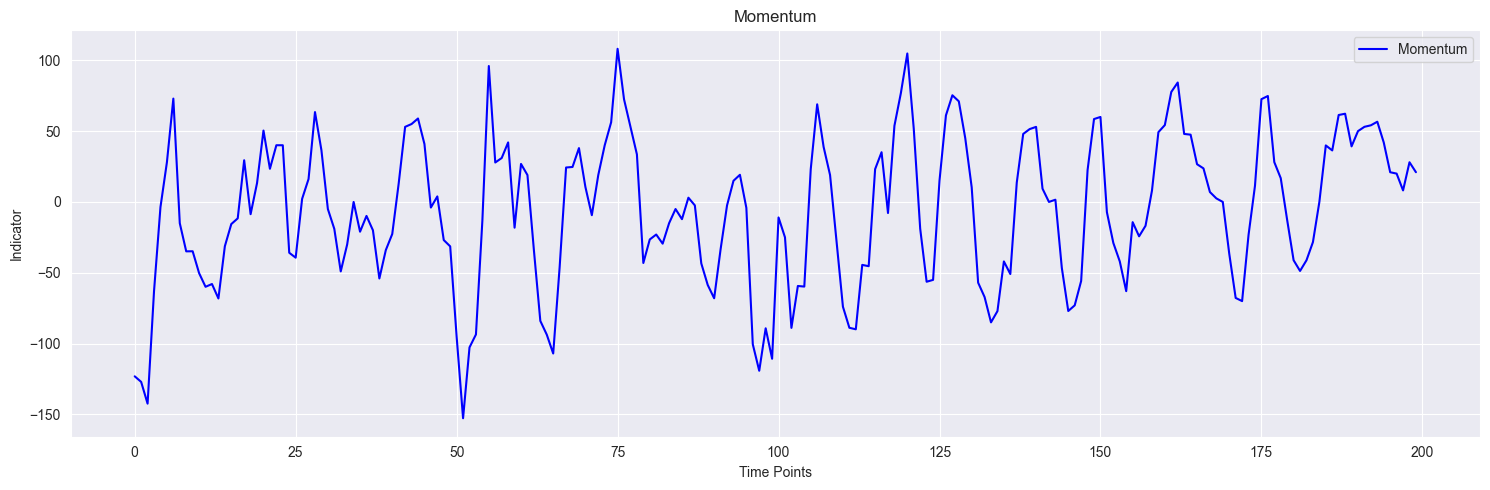

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.09
Date:                Sat, 11 May 2024   Prob (F-statistic):           0.000174
Time:                        13:05:00   Log-Likelihood:             1.5999e+07
No. Observations:             2958588   AIC:                        -3.200e+07
Df Residuals:                 2958586   BIC:                        -3.200e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.054e-07   6.31e-07      1.277      0.2

In [4]:
# Momentum 
# Momentum is the rate of acceleration of a security's price or volume. In technical analysis, momentum is considered an oscillator and is used to help identify trend lines. In general, momentum refers to the tendency of prices to continue moving in the same direction.   
btc_data_raw['Momentum'] = btc_data_raw['close'] - btc_data_raw['close'].shift(4)
easy_plot(btc_data_raw, 'Momentum', show_subplot=True)
linear_reg(btc_data_raw, ['Momentum'], show_summary=True)

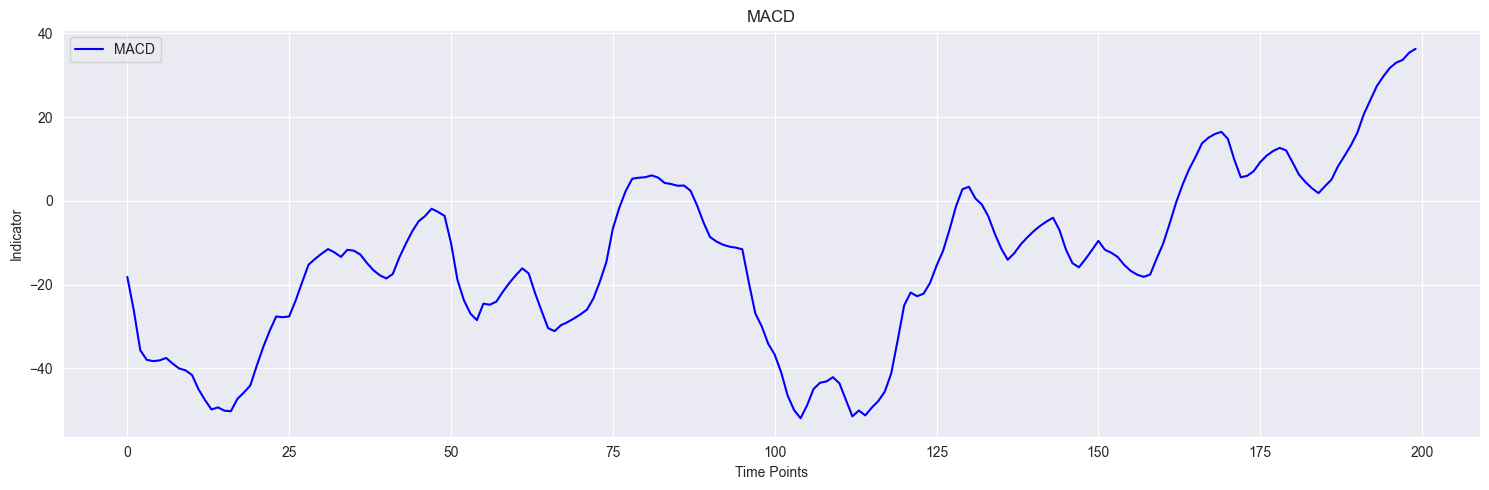

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     305.9
Date:                Sat, 11 May 2024   Prob (F-statistic):           1.76e-68
Time:                        13:05:01   Log-Likelihood:             1.5999e+07
No. Observations:             2958588   AIC:                        -3.200e+07
Df Residuals:                 2958586   BIC:                        -3.200e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.149e-07   6.31e-07      1.292      0.1

In [5]:
# MACD
# Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA. The result of that calculation is the MACD line. A nine-day EMA of the MACD called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. Traders may buy the security when the MACD crosses above its signal line and sell - or short - the security when the MACD crosses below the signal line. Moving average convergence divergence (MACD) indicators can be interpreted in several ways, but the more common methods are crossovers, divergences, and rapid rises/falls.

btc_data_raw['EMA12'] = btc_data_raw['close'].ewm(span=12, adjust=False).mean()
btc_data_raw['EMA26'] = btc_data_raw['close'].ewm(span=26, adjust=False).mean()
btc_data_raw['MACD'] = btc_data_raw['EMA12'] - btc_data_raw['EMA26']
easy_plot(btc_data_raw, 'MACD', show_subplot=True)
linear_reg(btc_data_raw, ['MACD'], True)

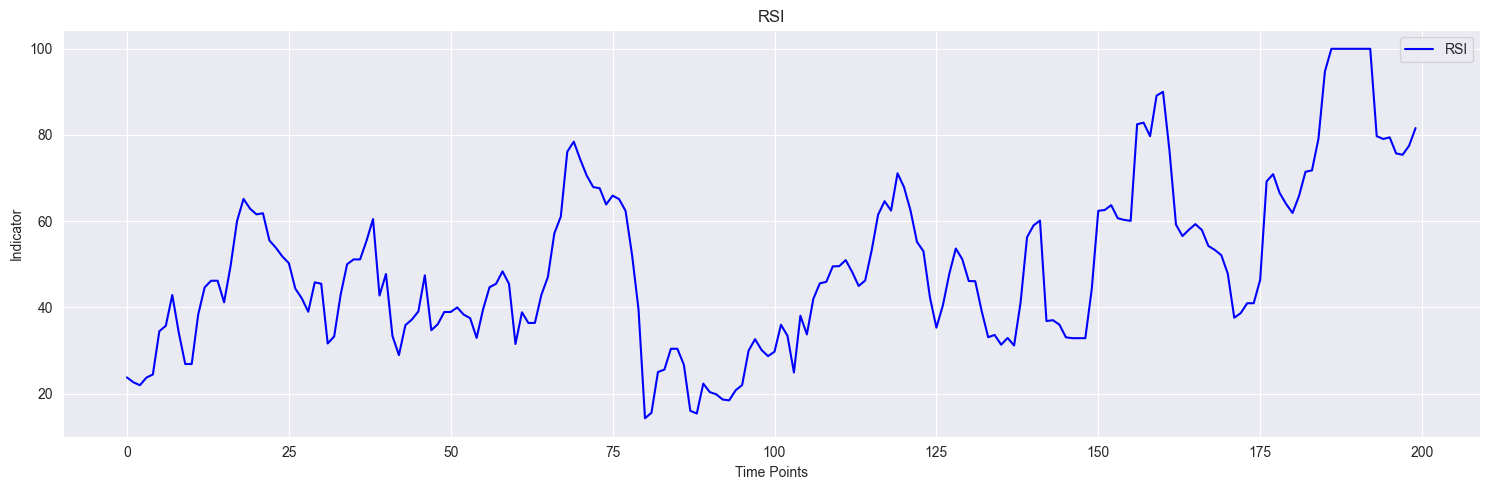

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     38.34
Date:                Sat, 11 May 2024   Prob (F-statistic):           5.95e-10
Time:                        13:05:03   Log-Likelihood:             1.5998e+07
No. Observations:             2958428   AIC:                        -3.200e+07
Df Residuals:                 2958426   BIC:                        -3.200e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.387e-06   1.76e-06     -5.325      0.0

In [6]:
# RSI
# The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.    
delta = btc_data_raw['close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
btc_data_raw['RSI'] = 100 - (100 / (1 + rs))
easy_plot(btc_data_raw, 'RSI', show_subplot=True)
linear_reg(btc_data_raw, ['RSI'], True)


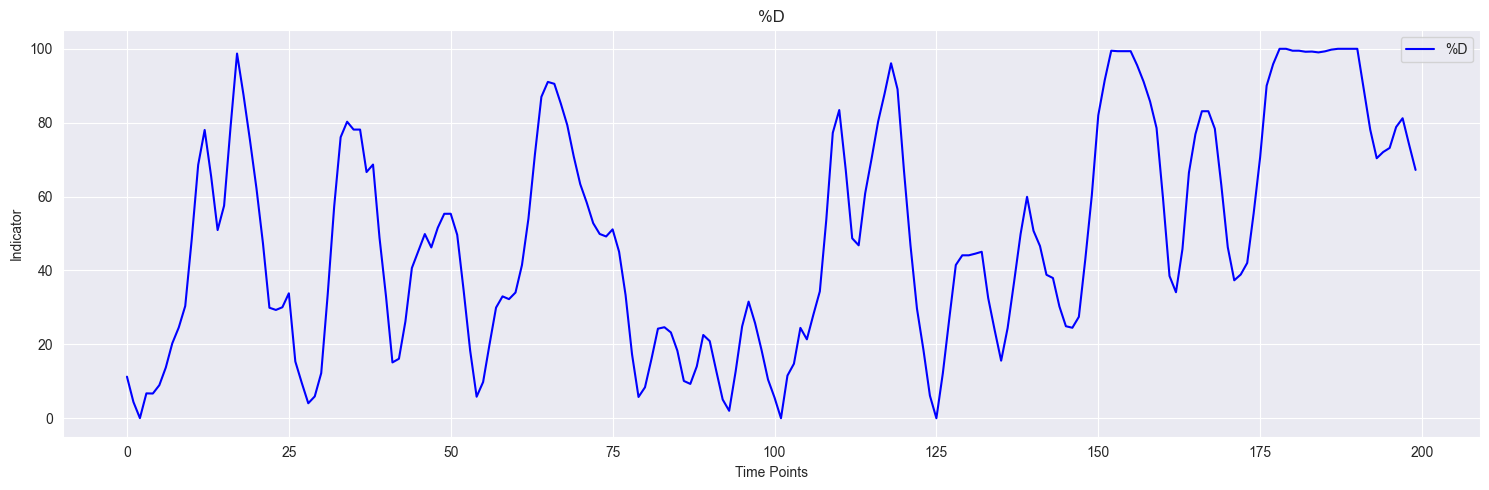

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     50.37
Date:                Sat, 11 May 2024   Prob (F-statistic):           1.27e-12
Time:                        13:05:05   Log-Likelihood:             1.5998e+07
No. Observations:             2958426   AIC:                        -3.200e+07
Df Residuals:                 2958424   BIC:                        -3.200e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.903e-06   1.26e-06     -5.496      0.0

In [7]:
# Stochastic Oscillator
# The Stochastic Oscillator is a bounded oscillator, meaning that its values are limited to a range between 0 and 100, which makes it useful for identifying overbought and oversold conditions. In general, a value of %K above 80 may indicate that the security is overbought, while a value below 20 may indicate that the security is oversold. However, these thresholds are not hard and fast rules, and traders often look for confirmation from other indicators or patterns before making a trade decision.
btc_data_raw['L14'] = btc_data_raw['low'].rolling(window=14).min()
btc_data_raw['H14'] = btc_data_raw['high'].rolling(window=14).max()
btc_data_raw['%K'] = 100 * ((btc_data_raw['close'] - btc_data_raw['L14']) / (btc_data_raw['H14'] - btc_data_raw['L14']))
btc_data_raw['%D'] = btc_data_raw['%K'].rolling(window=3).mean()
easy_plot(btc_data_raw, '%D', show_subplot=True)
linear_reg(btc_data_raw, ['%D'], True)


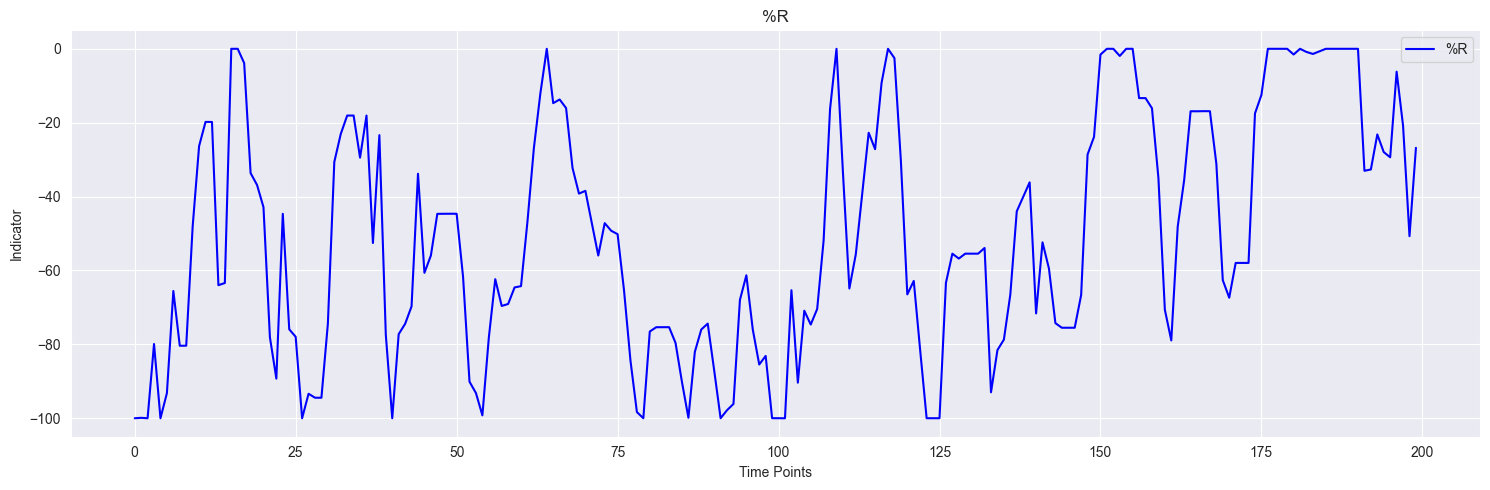

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sat, 11 May 2024   Prob (F-statistic):           4.40e-78
Time:                        13:05:07   Log-Likelihood:             1.5998e+07
No. Observations:             2958426   AIC:                        -3.200e+07
Df Residuals:                 2958424   BIC:                        -3.200e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.854e-05   1.14e-06     16.285      0.0

In [8]:
# Williams %R
# The Williams %R indicator is used to identify overbought and oversold conditions in a market. An asset is generally considered overbought when the Williams %R value is above -20 and oversold when the value is below -80. These levels indicate that an asset's price may be at an extreme compared to recent prices and could be due for a reversal.
btc_data_raw['%R'] = -100 * ((btc_data_raw['H14'] - btc_data_raw['close']) / (btc_data_raw['H14'] - btc_data_raw['L14']))
easy_plot(btc_data_raw, '%R', show_subplot=True)
linear_reg(btc_data_raw, ['%R'], True)

# B. Volatility Indicators: BollingerB_Middle, BollingerB_Upper, BollingerB_Lower, Standard_Deviation, ATR

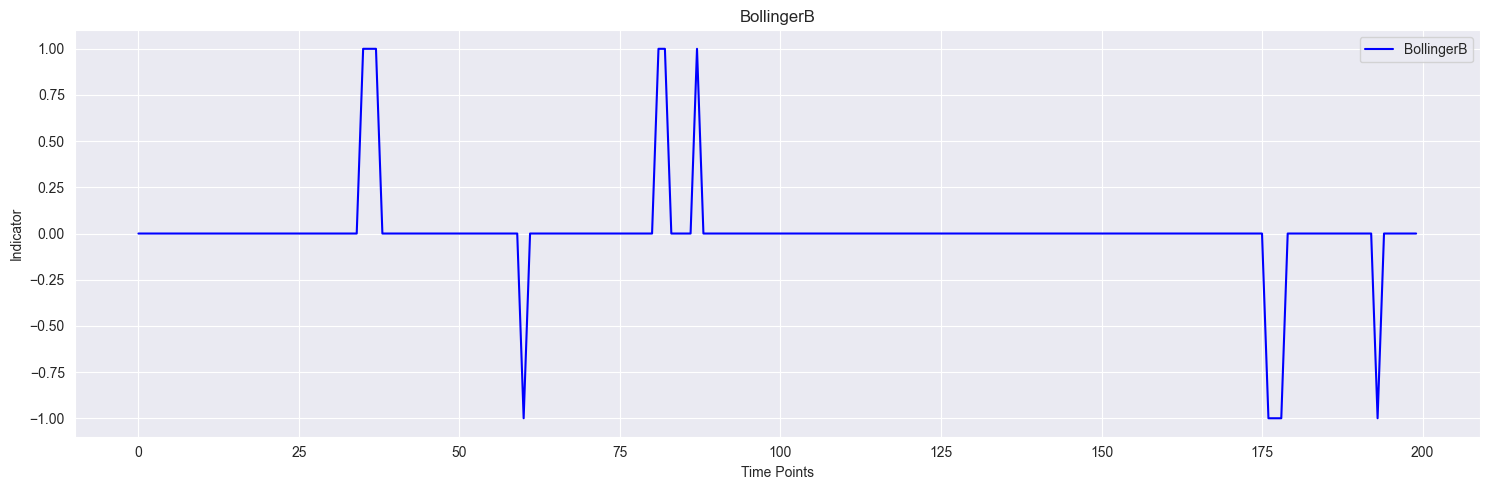

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     50.35
Date:                Sat, 11 May 2024   Prob (F-statistic):           1.28e-12
Time:                        13:05:10   Log-Likelihood:             1.5998e+07
No. Observations:             2958422   AIC:                        -3.200e+07
Df Residuals:                 2958420   BIC:                        -3.200e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.342e-07   6.31e-07      1.323      0.1

In [9]:
# Bollinger Bands
# Bollinger Bands are a type of statistical chart characterizing the prices and volatility over time of a financial instrument or commodity, using a formulaic method propounded by John Bollinger in the 1980s. Financial traders employ these charts as a methodical tool to inform trading decisions, control automated trading systems, or as a component of technical analysis. Bollinger Bands display a graphical band (the envelope maximum and minimum of moving averages, similar to Keltner or Donchian channels) and volatility (expressed by the width of the envelope) in one two-dimensional chart.
# The middle band is a simple moving average (SMA) of closing prices, usually over the last 20 periods.
# The upper band is calculated by adding K times the standard deviation (SD) of the closing price over the last 20 periods to the middle band.  
# The lower band is calculated by subtracting K times the SD of the closing price over the last 20 periods from the middle band.

btc_data_raw['BollingerB_Middle'] = btc_data_raw['close'].rolling(window=20).mean()
btc_data_raw['BollingerB_Upper'] = btc_data_raw['BollingerB_Middle'] + 2 * btc_data_raw['close'].rolling(window=20).std()
btc_data_raw['BollingerB_Lower'] = btc_data_raw['BollingerB_Middle'] - 2 * btc_data_raw['close'].rolling(window=20).std()
# If the price is higher than the upper band, then the security is overbought, if the price is lower than the lower band, then the security is oversold
btc_data_raw['BollingerB'] = np.where(btc_data_raw['close'] > btc_data_raw['BollingerB_Upper'], -1, np.where(btc_data_raw['close'] < btc_data_raw['BollingerB_Lower'], 1, 0))
easy_plot(btc_data_raw, 'BollingerB', show_subplot=True)
linear_reg(btc_data_raw, ['BollingerB'], True)

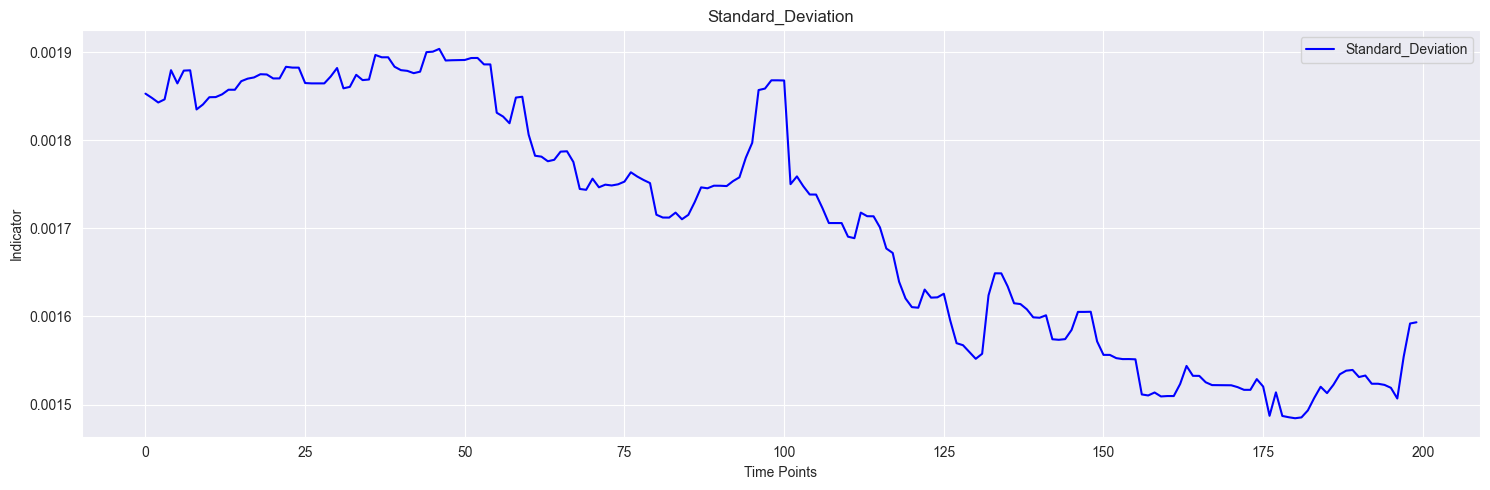

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     71.93
Date:                Sat, 11 May 2024   Prob (F-statistic):           2.24e-17
Time:                        13:05:13   Log-Likelihood:             1.5997e+07
No. Observations:             2958322   AIC:                        -3.199e+07
Df Residuals:                 2958320   BIC:                        -3.199e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5.605e-06   9.85

In [10]:
# Standard Deviation
# Standard deviation is a measure of the dispersion of a set of data from its mean. It is calculated as the square root of variance by determining the variation between each data point relative to the mean. If the data points are further from the mean, there is a higher deviation within the data set; thus, the more spread out the data, the higher the standard deviation.
btc_data_raw['Standard_Deviation'] = btc_data_raw['return'].rolling(window=120).std()
easy_plot(btc_data_raw, 'Standard_Deviation', show_subplot=True)
linear_reg(btc_data_raw, ['Standard_Deviation'], True)

# C. volumn indicators: OBV, MFI

In [11]:
# OBV 
# formula: OBV = (volume * sign(close - close1)).cumsum()   close1 is the previous close
# if a stock's price is increasing and OBV is also on an upward trend, this would generally be taken as a confirmation of the price trend. 
btc_data_raw['OBV'] = (btc_data_raw['volume'] * (~btc_data_raw['close'].diff().le(0) * 2 - 1)).cumsum()
# dropna if any
btc_data_raw = btc_data_raw.dropna()
# apply the regression analysis to the lagged return with respect to the OBV
reg = linear_reg(btc_data_raw, ['OBV'], True)


                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2819
Date:                Sat, 11 May 2024   Prob (F-statistic):              0.595
Time:                        13:05:16   Log-Likelihood:             1.5997e+07
No. Observations:             2958322   AIC:                        -3.199e+07
Df Residuals:                 2958320   BIC:                        -3.199e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.522e-08    1.7e-06     -0.015      0.9

In [12]:
# MFI
# The Money Flow Index (MFI) is a technical oscillator that uses both price and volume to measure buying and selling pressure. Like the Relative Strength Index (RSI), it's a bounded oscillator that moves between 0 and 100. Here's how you can use the MFI in your trading
# Money Flow Index = 100 - 100 / (1 + Money Flow Ratio)
# Money Flow Ratio = (Positive Money Flow / Negative Money Flow)
# Positive Money Flow = Sum of the money flows on the days in the period where the typical price is higher than the previous period's typical price
# Negative Money Flow = Sum of the money flows on the days in the period where the typical price is lower than the previous period's typical price

typical_price = (btc_data_raw['high'] + btc_data_raw['low'] + btc_data_raw['close']) / 3
money_flow = typical_price * btc_data_raw['volume']
positive_money_flow = money_flow.where(btc_data_raw['close'].diff(1) > 0, 0).rolling(window=14).sum()
negative_money_flow = money_flow.where(btc_data_raw['close'].diff(1) < 0, 0).rolling(window=14).sum()
money_flow_ratio = positive_money_flow / negative_money_flow
btc_data_raw['MFI'] = 100 - (100 / (1 + money_flow_ratio))
btc_data_raw = btc_data_raw.dropna()
# apply the regression analysis to the lagged return with respect to the MFI
reg = linear_reg(btc_data_raw, ['MFI'], True)


                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     31.50
Date:                Sat, 11 May 2024   Prob (F-statistic):           1.99e-08
Time:                        13:05:18   Log-Likelihood:             1.5997e+07
No. Observations:             2958309   AIC:                        -3.199e+07
Df Residuals:                 2958307   BIC:                        -3.199e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.169e-06   1.72e-06     -4.750      0.0

# D. Support & Resistance: Pivot_Point, Resistance1, Support1, Resistance2, Support2

In [13]:
# Pivot Point
# Pivot points are technical analysis indicators that represent an average of the high, low and closing prices from the prior trading day, and can be used to find likely support and resistance levels.
# Pivot Point (P) = (High + Low + Close) / 3
# Resistance 1 (R1) = (2 * P) - Low
# Support 1 (S1) = (2 * P) - High
# Resistance 2 (R2) = P + (R1 - S1)
# Support 2 (S2) = P - (R1 - S1)
btc_data_raw['Pivot_Point'] = (btc_data_raw['high'] + btc_data_raw['low'] + btc_data_raw['close']) / 3
btc_data_raw['Resistance1'] = (3 * btc_data_raw['Pivot_Point']) - btc_data_raw['low']
btc_data_raw['Support1'] = (3 * btc_data_raw['Pivot_Point']) - btc_data_raw['high']
btc_data_raw['Resistance2'] = btc_data_raw['Pivot_Point'] + (btc_data_raw['Resistance1'] - btc_data_raw['Support1'])
btc_data_raw['Support2'] = btc_data_raw['Pivot_Point'] - (btc_data_raw['Resistance1'] - btc_data_raw['Support1'])
# dropna if any
btc_data_raw = btc_data_raw.dropna()
# apply the regression analysis to the lagged return with respect to the Pivot_Point
reg = linear_reg(btc_data_raw, ['Pivot_Point'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.617
Date:                Sat, 11 May 2024   Prob (F-statistic):              0.203
Time:                        13:05:21   Log-Likelihood:             1.5997e+07
No. Observations:             2958309   AIC:                        -3.199e+07
Df Residuals:                 2958307   BIC:                        -3.199e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.853e-06   1.03e-06      1.793      

# E. Feature: liquidity

In [14]:
# please do liquidity analysis here
# the liquidity is defined as the ratio of the 30 minute rolling standard deviation of price return (close - open) / open to the volume
# calculate the liquidity
data = btc_data_raw.copy()
data['liquidity'] = data['return'].rolling(30).std() / data['volume'].rolling(30).median()
# drop the data where the liquidity is nan
data.dropna(inplace=True)

# calculate the rolling z score of liquidity
data['liquidity_z_score'] = (data['liquidity'] - data['liquidity'].rolling(30).mean()) / data['liquidity'].rolling(30).std()
# drop the data where the liquidity z score is nan
data.dropna(inplace=True)

# apply the regine change method to find the regime change points
# smooth the rolling z score of liquidity by using the rolling median
data['liquidity_z_score'] = data['liquidity_z_score'].rolling(5).median()
data.dropna(inplace=True)


In [15]:
# this MarkovAR is not used, because it's too slow to run, can ignore ths part !

import statsmodels.api as sm

class MarkovAR:

    def __init__(self, ts, lag, k, dr=True):
        '''
        ts : time series of your input data, type: pandas.series
        lag : the lag order in Auto Regression 
        k : number of regimes in the Markov Chain
        dr : bool, whether the slope coefficient vary across the regimes
        '''
        self.ts = ts
        self.lag = lag
        self.k = k
        self.dr = dr

    def fit(self):
        m = sm.tsa.MarkovRegression(endog = self.ts, k_regimes = self.k, order = self.lag, trend='n', switching_variance = True)
        self.res = m.fit()
        return self

    def get_smooth_prob(self, keep_all=False):
        '''
        keep_all : bool, whether to keep nan values in the smoothed probability dataframe
        '''
        df_p = pd.DataFrame()
        for i in range(self.k):
            df_p[f'Regime{i}'] = self.res.smoothed_marginal_probabilities[i]
        df_p['regime'] = df_p.idxmax(axis=1)
        if not keep_all:
            df_p = df_p.dropna()
        return df_p

    def get_transition_prob_mat(self):
        '''
        # Extracting the transition probabilities to form the transition matrix
        k : number of regimes
        res : fit result of the MSA (Markov Swithcing Autoregression) model
        '''
        transition_matrix = []

        # For each regime, extract the transition probabilities to other regimes
        for i in range(self.k):
            current_row = []
            for j in range(self.k):
                key = f'p[{i}->{j}]'
                if key in self.res.params:
                    current_row.append(self.res.params[key])
                else:
                    # If the probability is not directly provided, deduce it
                    current_row.append(1 - sum(current_row))
            transition_matrix.append(current_row)

        transition_matrix_df = pd.DataFrame(transition_matrix, columns=[f'To Regime{n}' for n in range(self.k)], index=[f'From Regime{n}' for n in range(self.k)])
        return transition_matrix_df

# # construct a df_input with columns liquidity_z_score and index datetime
# mar = MarkovAR(data.copy()['liquidity_z_score'], 1, 3, True).fit()
# print(mar.res.summary())
# df_p = mar.get_smooth_prob()
# df_p.head()
        

In [16]:
# model a regime swtching model based on the rolling z score of liquidity
# if the rolling z score of liquidity is lower than -1.5, then the regime is 0
# if the rolling z score of liquidity is between -1.5 and 1.5, then the regime is 1
# if the rolling z score of liquidity is higher than 1.5, then the regime is 2
data['regime'] = np.where(data['liquidity_z_score'] < -1.5, 0, np.where(data['liquidity_z_score'] > 1.5, 2, 1))
# see if regime is correlated with the lagged return
data['lagged_return'] = data['close'].pct_change().shift(-1)
# dropna if any
data.dropna(inplace=True)
# apply the regression analysis to the lagged return with respect to the regime
reg = linear_reg(data, ['regime'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3880
Date:                Sat, 11 May 2024   Prob (F-statistic):              0.533
Time:                        13:05:27   Log-Likelihood:             1.5997e+07
No. Observations:             2958246   AIC:                        -3.199e+07
Df Residuals:                 2958244   BIC:                        -3.199e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.579e-06   1.38e-06      1.140      0.2

In [17]:
data.columns

Index(['date', 'sym', 'open', 'high', 'low', 'close', 'volume', 'return',
       'lagged_return', 'Momentum', 'EMA12', 'EMA26', 'MACD', 'RSI', 'L14',
       'H14', '%K', '%D', '%R', 'BollingerB_Middle', 'BollingerB_Upper',
       'BollingerB_Lower', 'BollingerB', 'Standard_Deviation', 'OBV', 'MFI',
       'Pivot_Point', 'Resistance1', 'Support1', 'Resistance2', 'Support2',
       'liquidity', 'liquidity_z_score', 'regime'],
      dtype='object')

# Now, very important, we need to check the correlation between the features, and pick the features that are not highly correlated with each other, and the features that are highly correlated with the lagged return

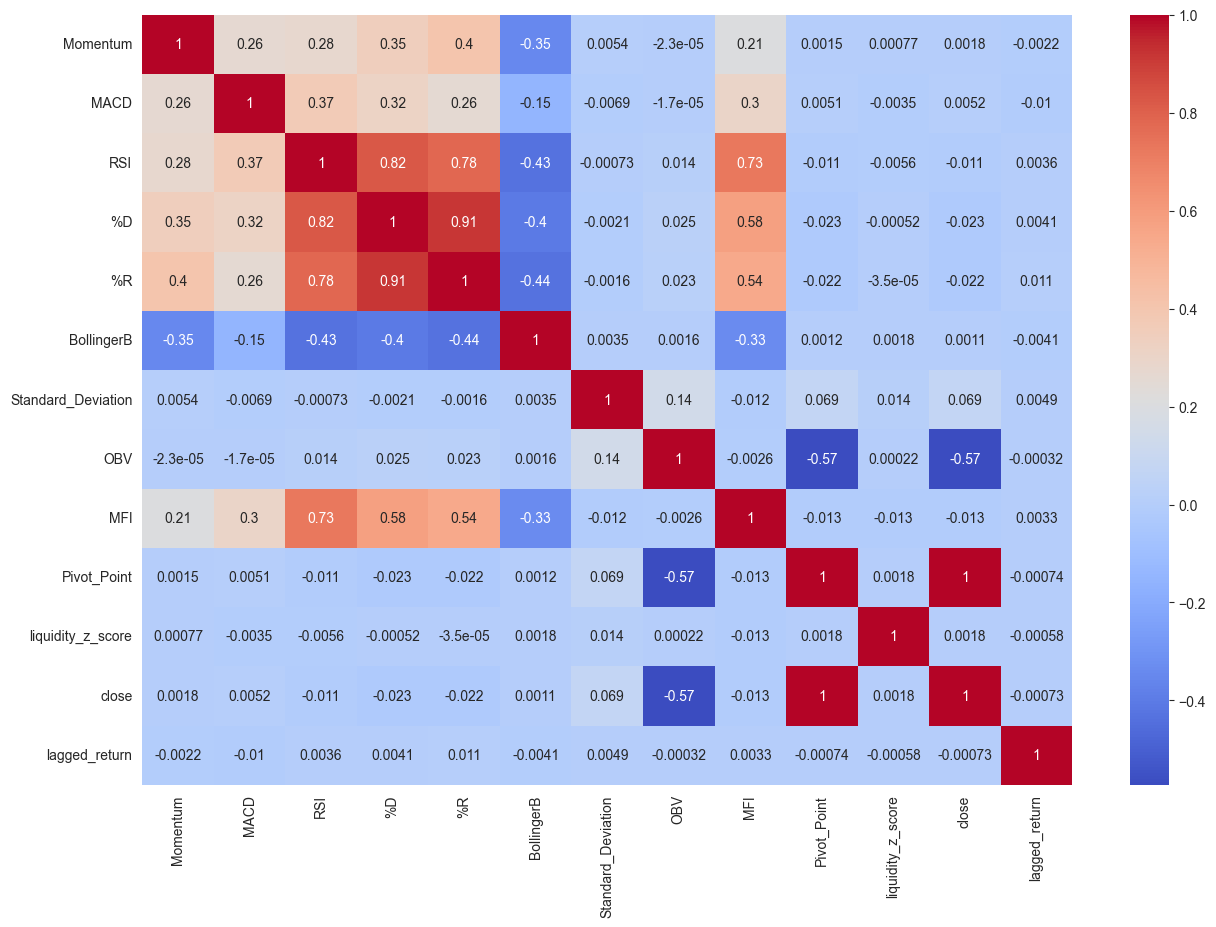

In [18]:
# create a correlation matrix for all features 
# only choose the feature created earlier
featurs = ['Momentum', 'MACD', 'RSI', '%D', '%R', 'BollingerB', 'Standard_Deviation', 'OBV', 'MFI', 'Pivot_Point', 'liquidity_z_score']
featurs += ['close', 'lagged_return']
corr = data.loc[:, featurs].corr()
# plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Write a function to group the combined features into different groups, their corr is higher than 0.6

In [19]:
def group_features(corr, threshold=0.5):
    """
    corr: a dataframe, the correlation matrix
    threshold: float, the threshold of the correlation
    """
    # create a list to store the groups
    groups = []
    # create a set to store the features that have been grouped
    grouped_features = set()
    # loop through the correlation matrix
    for i in range(corr.shape[0]):
        # if the feature has been grouped, then skip
        if i in grouped_features:
            continue
        # create a list to store the features that are highly correlated with the current feature
        group = []
        # loop through the correlation matrix
        for j in range(i + 1, corr.shape[0]):
            # if the feature has been grouped, then skip
            if j in grouped_features:
                continue
            # if the correlation is higher than the threshold, then add the feature to the group
            if corr.iloc[i, j] > threshold:
                group.append(corr.columns[j])
                grouped_features.add(j)
        # if the group is not empty, then add the group to the groups
        if len(group) > 0:
            groups.append([corr.columns[i]] + group)
    return groups

In [20]:
group_features(corr, 0.6)

[['RSI', '%D', '%R', 'MFI'], ['Pivot_Point', 'close']]

# Now it's time to build the factor model !!

# 1. Trend Signal: cross_over - equal weight moving average cross over
# An enhancement to MACD 

In [21]:
# Compute the Technical Indicators on the raw dataset
# trend indicators: cross_over - equal weight moving average cross over
# using the following parameters n = (3, 5, 10, 30), m = (15, 20, 30, 60), n_vol = 1440
data['cross_over_3_9'] = cross_over(data['close'], 3, 9)
data['cross_over_5_15'] = cross_over(data['close'], 5, 15)
data['cross_over_10_30'] = cross_over(data['close'], 10, 30)
data['cross_over_30_90'] = cross_over(data['close'], 30, 90)
# here is the weighted moving average cross over, called cross_over
# calculate the mean of the three cross_over, dropna if any
data['cross_over'] = data[['cross_over_3_9', 'cross_over_5_15', 'cross_over_10_30', 'cross_over_30_90']].mean(axis=1)
# keep the cross_over column and drop the cross_over_3_9, cross_over_5_15, cross_over_10_30, cross_over_30_90 columns
data = data.drop(['cross_over_3_9', 'cross_over_5_15', 'cross_over_10_30', 'cross_over_30_90'], axis=1)
# dropna if any
data = data.dropna()

# apply the regression analysis to the lagged return with respect to the cross_over signal 
reg = linear_reg(data, ['cross_over'], True)

# If the %D is above 80, then the security is overbought, if the %D is below 20, then the security is oversold
def apply_so(data, threshold=80):
    data['L14'] = data['low'].rolling(window=14).min()
    data['H14'] = data['high'].rolling(window=14).max()
    data['%K'] = 100 * ((data['close'] - data['L14']) / (data['H14'] - data['L14']))
    data['%D'] = data['%K'].rolling(window=3).mean()
    # If the %D is above 80, then the security is overbought, if the %D is below 20, then the security is oversold
    data['SO'] = np.where(data['%D'] > threshold, -1, np.where(data['%D'] < (100-threshold), 1, 0))
    return data

# apply the SO to the data
data = apply_so(data)
data['cross_over'] = data['cross_over'] * data['SO']
# dropna if any
data = data.dropna()
reg = linear_reg(data, ['cross_over'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     23.03
Date:                Sat, 11 May 2024   Prob (F-statistic):           1.59e-06
Time:                        13:05:32   Log-Likelihood:             1.5991e+07
No. Observations:             2957094   AIC:                        -3.198e+07
Df Residuals:                 2957092   BIC:                        -3.198e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        8.42e-07   6.31e-07      1.335      0.1

# 2. Volatility Signal: Standard_Deviation

In [23]:
# use the change of sd to indicate the volatility risk premium signal 
lookback = 80
data['risk_premium'] =  (data['Standard_Deviation'] - data['Standard_Deviation'].shift(lookback))
data['risk_premium'] = data['risk_premium'].rolling(5).median()
data['risk_premium'] = data['risk_premium'].dropna()
data['risk_premium'] = np.where(data['risk_premium'] > 0.005, 1, np.where(data['risk_premium'] < -0.005, -1, 0))
# dropna if any
data = data.dropna()
# apply the regression analysis to the lagged return with respect to the risk_premium
reg = linear_reg(data, ['risk_premium'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.83
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           0.000584
Time:                        11:49:18   Log-Likelihood:             1.5991e+07
No. Observations:             2957079   AIC:                        -3.198e+07
Df Residuals:                 2957077   BIC:                        -3.198e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.987e-07   6.31e-07      1.267   

In [24]:
# apply the regression analysis to the lagged return with respect to the signal_z
reg = linear_reg(data, ['cross_over', 'risk_premium'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     96.34
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           1.46e-42
Time:                        11:49:19   Log-Likelihood:             1.5991e+07
No. Observations:             2957079   AIC:                        -3.198e+07
Df Residuals:                 2957076   BIC:                        -3.198e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.136e-06   6.67e-07     -3.200   

# 3. Reference Signal 

a. SO (stocalstic oscillator)
b. MFI (money flow index)
c. Regime (regime)




In [25]:
# a. First add SO to the data
def apply_so(data, threshold=80):
    data['L14'] = data['low'].rolling(window=14).min()
    data['H14'] = data['high'].rolling(window=14).max()
    data['%K'] = 100 * ((data['close'] - data['L14']) / (data['H14'] - data['L14']))
    data['%D'] = data['%K'].rolling(window=3).mean()
    # If the %D is above 80, then the security is overbought, if the %D is below 20, then the security is oversold
    data['SO'] = np.where(data['%D'] > threshold, -1, np.where(data['%D'] < (100-threshold), 1, 0))
    return data

data = apply_so(data)
# dropna if any
data = data.dropna()
# apply the regression analysis to the lagged return with respect to the SO
reg = linear_reg(data, ['SO'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.22
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           0.000808
Time:                        11:49:21   Log-Likelihood:             1.5991e+07
No. Observations:             2957064   AIC:                        -3.198e+07
Df Residuals:                 2957062   BIC:                        -3.198e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.992e-07   6.31e-07      1.107      0.2

In [26]:
# apply the regression analysis to the lagged return with respect to the signal_z
reg = linear_reg(data, ['cross_over', 'risk_premium', 'SO'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     67.26
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           1.75e-43
Time:                        11:49:22   Log-Likelihood:             1.5991e+07
No. Observations:             2957064   AIC:                        -3.198e+07
Df Residuals:                 2957060   BIC:                        -3.198e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.218e-06   6.68e-07     -3.322   

In [27]:
# b. add MFI to the data
def apply_mfi(data, threshold=80):
    data['typical_price'] = (data['high'] + data['low'] + data['close']) / 3
    data['money_flow'] = data['typical_price'] * data['volume']
    data['positive_money_flow'] = np.where(data['typical_price'] > data['typical_price'].shift(1), data['money_flow'], 0)
    data['negative_money_flow'] = np.where(data['typical_price'] < data['typical_price'].shift(1), data['money_flow'], 0)
    data['positive_money_flow_sum'] = data['positive_money_flow'].rolling(window=14).sum()
    data['negative_money_flow_sum'] = data['negative_money_flow'].rolling(window=14).sum()
    data['money_flow_ratio'] = data['positive_money_flow_sum'] / data['negative_money_flow_sum']
    data['money_flow_index'] = 100 - (100 / (1 + data['money_flow_ratio']))
    data['MFI'] = np.where(data['money_flow_index'] > threshold, -1, np.where(data['money_flow_index'] < (100-threshold), 1, 0))
    data['MFI'] = data['MFI'] * data['cross_over']
    return data

data = apply_mfi(data)
# dropna if any
data = data.dropna()
# apply the regression analysis to the lagged return with respect to the MFI
reg = linear_reg(data, ['MFI'], True)


                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     48.99
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           2.57e-12
Time:                        11:49:25   Log-Likelihood:             1.5991e+07
No. Observations:             2957051   AIC:                        -3.198e+07
Df Residuals:                 2957049   BIC:                        -3.198e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.601e-07   6.31e-07      1.364      0.1

In [28]:
# apply the regression analysis to the lagged return with respect to the signal_z
reg = linear_reg(data, ['cross_over', 'risk_premium', 'SO', 'MFI'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     69.14
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           1.24e-58
Time:                        11:49:26   Log-Likelihood:             1.5991e+07
No. Observations:             2957051   AIC:                        -3.198e+07
Df Residuals:                 2957046   BIC:                        -3.198e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.265e-06   6.68e-07     -3.391   

In [29]:
# c. Add Regime to the data
def apply_regime(data):
    data['regime'] = np.where(data['liquidity_z_score'] < -2, 1, np.where(data['liquidity_z_score'] > 2, 0.3, 0.7))
    data['regime'] = data['cross_over'] * data['regime']
    return data

data = apply_regime(data)
# dropna if any
data = data.dropna()
# apply the regression analysis to the lagged return with respect to the regime
reg = linear_reg(data, ['regime'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     158.0
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           3.12e-36
Time:                        11:49:28   Log-Likelihood:             1.5991e+07
No. Observations:             2957051   AIC:                        -3.198e+07
Df Residuals:                 2957049   BIC:                        -3.198e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -1.9e-06   6.66e-07     -2.851      0.0

In [30]:
# apply the regression analysis to the lagged return with respect to the signal_z   
reg = linear_reg(data, ['cross_over', 'risk_premium', 'SO', 'MFI', 'regime'], True)

                            OLS Regression Results                            
Dep. Variable:          lagged_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     56.49
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           5.91e-59
Time:                        11:49:30   Log-Likelihood:             1.5991e+07
No. Observations:             2957051   AIC:                        -3.198e+07
Df Residuals:                 2957045   BIC:                        -3.198e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.235e-06   6.68e-07     -3.346   

# In sample backtest 

In [31]:
# get the 80% in sample data
rows = len(btc_data_raw)
insample = int(rows * 0.8)
data_os = data.iloc[insample:]
data = data.iloc[:insample]
data.tail()

,date,sym,open,high,low,close,volume,return,lagged_return,Momentum,...,SO,risk_premium,typical_price,money_flow,positive_money_flow,negative_money_flow,positive_money_flow_sum,negative_money_flow_sum,money_flow_ratio,money_flow_index
datetime,,,,,,,,,,,,,,,,,,,,,
2022-07-05 18:07:00,2022-07-05,BTCUSD,19666.1200,19684.9900,19662.7100,19668.8000,22.0286,0.0002,-0.0005,-23.0900,...,1,0,19672.1667,433351.0061,0.0000,433351.0061,2832018.2272,3643247.5820,0.7773,43.7359
2022-07-05 18:08:00,2022-07-05,BTCUSD,19668.8000,19671.8900,19657.3100,19658.7900,11.7765,-0.0005,0.0004,-27.8900,...,1,0,19662.6633,231557.8506,0.0000,231557.8506,2617577.4159,3874805.4326,0.6755,40.3177
2022-07-05 18:09:00,2022-07-05,BTCUSD,19659.5000,19668.3400,19653.0000,19667.3100,10.8835,0.0004,0.0000,-15.7800,...,1,0,19662.8833,214000.4772,214000.4772,0.0000,2831577.8931,3303464.5003,0.8572,46.1542
2022-07-05 18:10:00,2022-07-05,BTCUSD,19667.3800,19676.3200,19665.1700,19667.3200,9.2883,0.0000,0.0003,2.0700,...,1,0,19669.6033,182697.7353,182697.7353,0.0000,3014275.6283,2977794.3385,1.0123,50.3044
2022-07-05 18:11:00,2022-07-05,BTCUSD,19666.8700,19677.7700,19665.1000,19673.1900,5.3633,0.0003,0.0013,4.3900,...,1,0,19672.0200,105507.4510,105507.4510,0.0000,3119783.0794,2550752.8652,1.2231,55.0174


In [32]:
# backtest trends
def cal_max_dd(data):
    cum_max = data.cummax()
    drawdown = data - cum_max
    max_drawdown = drawdown.min()
    return max_drawdown * 100
    
def mini_backtest(df_input, prediction):
    df = df_input.copy()
    avg_abs_pos = df['POS'].abs().mean()
    gross_return = df[prediction].mean() * 100 * 252 * 60 * 24
    net_return = (df[prediction] - df['TC']).mean() * 100 * 252 * 60 * 24
    vol = df[prediction].std() * 100 * np.sqrt(252 * 60 * 24)
    gross_sr = df[prediction].mean() * 100 * 252 * 60 * 24 / vol
    net_sr = (df[prediction] - df['TC']).mean() * 100 * 252 * 60 * 24 / vol
    tc = df['TC'].mean() * 100 * 252 * 60 * 24
    signal_turnover = df['POS'].diff().fillna(0).abs().mean() * 252  * 60 * 24
    max_dd = cal_max_dd(df[prediction].cumsum())
    
    return pd.Series(
        [avg_abs_pos, gross_return, net_return, vol, gross_sr, net_sr, tc, signal_turnover, max_dd],
        index = ['avg_abs_pos', 'gross_return', 'net_return', 'vol', 'gross_sr',
                 'net_sr', 'tc', 'signal_turnover', 'max_dd']  
    )

def run_backtest_trends(signal_df, lookback_window = [2,3,4,8,16,32], prediction = 'lagged_return', use_so = False, use_mfi = False, use_regime= False):
    res_stat = []
    res_gross_pnl = []
    res_net_pnl = []
    for lookback in lookback_window: 
        lookback_1 = lookback 
        lookback_2 = lookback_1 * 3 
        """
        SIGNAL HERE 
        """
        signal_df['signal'] = cross_over(signal_df['close'], lookback_1, lookback_2)
        signal_df['signal_z'] = signal_df['signal'].clip(-1, 1)
        if use_so:
            # trade only SO and signal_z are the same sign 
            signal_df = apply_so(signal_df, 80)
        if use_mfi:
            signal_df = apply_mfi(signal_df, 80)
        if use_regime:
            signal_df = apply_regime(signal_df)
        
        signal_df['POS'] = signal_df['signal_z'] 
        signal_df['STRATEGY_RUN'] = signal_df['signal_z'] * signal_df[prediction]
        signal_df['TC'] = 0
        res_stat.append(pd.DataFrame(mini_backtest(signal_df, "STRATEGY_RUN"), columns=[f"lookback_{lookback}"]))
        res_gross_pnl.append(signal_df["STRATEGY_RUN"])
        # res_net_pnl.append(signal_df["STRATEGY_RUN"] - signal_df["TC"])
    stats_df = pd.concat(res_stat, axis=1)
    return res_gross_pnl, stats_df

In [33]:
def apply_so(data, threshold=80):
    data['L14'] = data['low'].rolling(window=14).min()
    data['H14'] = data['high'].rolling(window=14).max()
    data['%K'] = 100 * ((data['close'] - data['L14']) / (data['H14'] - data['L14']))
    data['%D'] = data['%K'].rolling(window=3).mean()
    # If the %D is above 80, then the security is overbought, if the %D is below 20, then the security is oversold
    data['SO'] = np.where(data['%D'] > threshold, 1, np.where(data['%D'] < (100-threshold), -1, 0))
    data['signal_z'] = data['signal_z'] * data['SO']
    return data

def apply_mfi(data, threshold=80):
    data['typical_price'] = (data['high'] + data['low'] + data['close']) / 3
    data['money_flow'] = data['typical_price'] * data['volume']
    data['positive_money_flow'] = np.where(data['typical_price'] > data['typical_price'].shift(1), data['money_flow'], 0)
    data['negative_money_flow'] = np.where(data['typical_price'] < data['typical_price'].shift(1), data['money_flow'], 0)
    data['positive_money_flow_sum'] = data['positive_money_flow'].rolling(window=14).sum()
    data['negative_money_flow_sum'] = data['negative_money_flow'].rolling(window=14).sum()
    data['money_flow_ratio'] = data['positive_money_flow_sum'] / data['negative_money_flow_sum']
    data['money_flow_index'] = 100 - (100 / (1 + data['money_flow_ratio']))
    data['MFI'] = np.where(data['money_flow_index'] > threshold, -1, np.where(data['money_flow_index'] < (100-threshold), 1, 0))
    data['signal_z'] = data['signal_z'] * data['MFI']
    return data

def apply_regime(data):
    # if the regime is 0, then the signal is still as it is
    # if the regime is 1, then the signal is 0.7
    # if the regime is 2, then the signal is 0.3
    data['signal_z'] = np.where(data['regime'] == 0, data['signal_z'], np.where(data['regime'] == 1, data['signal_z'] * 0.7, data['signal_z'] * 0.3))
    return data

In [34]:
lookback_window = [2,3,4,8,16,32]
res_gross_pnl, stats_df = run_backtest_trends(data, use_so=True, use_mfi=False, use_regime=False, lookback_window=lookback_window)
trends_signal = res_gross_pnl.copy() 
for v, lookback in zip(trends_signal, lookback_window):
    v.name = f"trends_lookback_{lookback}"
stats_df

,lookback_2,lookback_3,lookback_4,lookback_8,lookback_16,lookback_32
avg_abs_pos,0.3081,0.2884,0.2582,0.2176,0.2131,0.2183
gross_return,114.0017,105.0568,101.9649,74.8448,50.0772,31.1507
net_return,114.0017,105.0568,101.9649,74.8448,50.0772,31.1507
vol,45.2402,44.1753,42.4945,39.7075,38.4279,38.0932
gross_sr,2.5199,2.3782,2.3995,1.8849,1.3031,0.8178
net_sr,2.5199,2.3782,2.3995,1.8849,1.3031,0.8178
tc,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
signal_turnover,46471.8281,39371.3483,36106.8830,33711.4558,31097.9537,29700.1506
max_dd,-55.8358,-56.4580,-50.0051,-52.9782,-69.6788,-68.2599


Text(0.5, 1.0, '[In Sample] BTC CumRet Trends + Stocastic Oscillator')

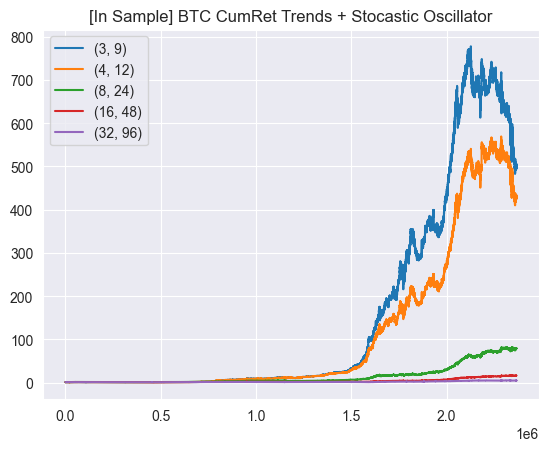

In [35]:
import matplotlib.pyplot as plt
for lookback, pnl in zip(lookback_window[1:], res_gross_pnl[1:]):
    p = (pnl + 1).cumprod().reset_index(drop=True).plot(label=f'({lookback}, {lookback * 3})')
plt.legend(loc="best")
plt.title("[In Sample] BTC CumRet Trends + Stocastic Oscillator")

In [36]:
lookback_window = [2,3,4,8,16,32]
res_gross_pnl, stats_df = run_backtest_trends(data, use_so=True, use_mfi=False, use_regime=True, lookback_window=lookback_window)
trends_signal = res_gross_pnl.copy() 
for v, lookback in zip(trends_signal, lookback_window):
    v.name = f"trends_lookback_{lookback}"
stats_df

,lookback_2,lookback_3,lookback_4,lookback_8,lookback_16,lookback_32
avg_abs_pos,0.0924,0.0865,0.0775,0.0653,0.0639,0.0655
gross_return,34.2005,31.5170,30.5895,22.4534,15.0232,9.3452
net_return,34.2005,31.5170,30.5895,22.4534,15.0232,9.3452
vol,13.5721,13.2526,12.7483,11.9122,11.5284,11.4279
gross_sr,2.5199,2.3782,2.3995,1.8849,1.3031,0.8178
net_sr,2.5199,2.3782,2.3995,1.8849,1.3031,0.8178
tc,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
signal_turnover,13941.5484,11811.4045,10832.0649,10113.4367,9329.3861,8910.0452
max_dd,-16.7508,-16.9374,-15.0015,-15.8934,-20.9036,-20.4780


Text(0.5, 1.0, '[In Sample] BTC CumRet Trends + Stocastic Oscillator + Regime')

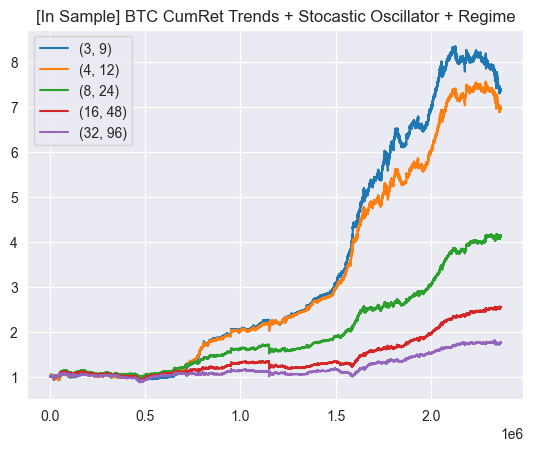

In [37]:
import matplotlib.pyplot as plt
for lookback, pnl in zip(lookback_window[1:], res_gross_pnl[1:]):
    p = (pnl + 1).cumprod().reset_index(drop=True).plot(label=f'({lookback}, {lookback * 3})')
plt.legend(loc="best")
plt.title("[In Sample] BTC CumRet Trends + Stocastic Oscillator + Regime")

In [38]:
# backtest vol 
# use the change of sd to indicate the volatility risk premium signal 
def get_vol_premium_signal(data, lookback, vol_lookback, smooth_window=5): 
    data['Standard_Deviation'] = data['return'].rolling(window=vol_lookback).std()
    data['risk_premium'] = data['Standard_Deviation'].diff(lookback)
    data['risk_premium'] = data['risk_premium'].rolling(smooth_window).median()
    data['risk_premium'] = data['risk_premium'].dropna()
    data['signal'] = np.where(data['risk_premium'] > 0, 1, np.where(data['risk_premium'] < 0, -1, 0))
    return data

def apply_so(data, threshold=80):
    data['L14'] = data['low'].rolling(window=14).min()
    data['H14'] = data['high'].rolling(window=14).max()
    data['%K'] = 100 * ((data['close'] - data['L14']) / (data['H14'] - data['L14']))
    data['%D'] = data['%K'].rolling(window=3).mean()
    # If the %D is above 80, then the security is overbought, if the %D is below 20, then the security is oversold
    data['SO'] = np.where(data['%D'] > threshold, -1, np.where(data['%D'] < (100-threshold), 1, 0))
    return data

def run_backtest_volpremium(signal_df, lookback_window, vol_lookback_window,
                 prediction = 'lagged_return', use_so = False,
                 use_mfi = False):
    res_stat = []
    res_gross_pnl = []
    res_net_pnl = []
    for lookback in lookback_window: 
        """
        SIGNAL HERE 
        """
        for vol_lookback in vol_lookback_window:
            signal_df = get_vol_premium_signal(signal_df, lookback, vol_lookback)
            signal_df['signal_z'] = signal_df['signal'].clip(-1, 1)
            if use_so:
                # trade only SO and signal_z are the same sign 
                signal_df = apply_so(signal_df, 80)
                signal_df['signal_z'] = signal_df['signal_z'] * signal_df['SO']
            if use_mfi:
                signal_df = apply_mfi(signal_df, 80)
                signal_df['signal_z'] = signal_df['signal_z'] * signal_df['MFI']
            
            signal_df['POS'] = signal_df['signal_z'] 
            signal_df['STRATEGY_RUN'] = signal_df['signal_z'] * signal_df[prediction]
            signal_df['TC'] = 0
            res_stat.append(pd.DataFrame(mini_backtest(signal_df, "STRATEGY_RUN"), columns=[f"lookback_{lookback} vol_lookback_{vol_lookback}"]))
            res_gross_pnl.append(signal_df["STRATEGY_RUN"])
            # res_net_pnl.append(signal_df["STRATEGY_RUN"] - signal_df["TC"])
    stats_df = pd.concat(res_stat, axis=1)
    return res_gross_pnl, stats_df

In [39]:
lookback_window = [10, 20, 40, 80, 160, 320, 640, 1280, 2560]
vol_lookback_window = [40, 80]
res_gross_pnl, stats_df = run_backtest_volpremium(data, use_so=False, use_mfi=False, lookback_window=lookback_window, vol_lookback_window=vol_lookback_window)
vol_signal = res_gross_pnl.copy()
stats_df

,lookback_10 vol_lookback_40,lookback_10 vol_lookback_80,lookback_20 vol_lookback_40,lookback_20 vol_lookback_80,lookback_40 vol_lookback_40,lookback_40 vol_lookback_80,lookback_80 vol_lookback_40,lookback_80 vol_lookback_80,lookback_160 vol_lookback_40,lookback_160 vol_lookback_80,lookback_320 vol_lookback_40,lookback_320 vol_lookback_80,lookback_640 vol_lookback_40,lookback_640 vol_lookback_80,lookback_1280 vol_lookback_40,lookback_1280 vol_lookback_80,lookback_2560 vol_lookback_40,lookback_2560 vol_lookback_80
avg_abs_pos,1.0000,0.9999,1.0000,1.0000,1.0000,0.9999,0.9999,0.9999,0.9999,0.9999,0.9998,0.9998,0.9997,0.9997,0.9994,0.9994,0.9989,0.9989
gross_return,36.7510,49.3418,25.8248,23.6367,21.8342,25.2460,26.4357,44.1611,39.5842,61.7446,46.7258,57.3404,44.3239,47.1920,-0.1638,9.7281,65.6681,47.5569
net_return,36.7510,49.3418,25.8248,23.6367,21.8342,25.2460,26.4357,44.1611,39.5842,61.7446,46.7258,57.3404,44.3239,47.1920,-0.1638,9.7281,65.6681,47.5569
vol,69.9949,69.9931,69.9947,69.9926,69.9939,69.9922,69.9922,69.9913,69.9887,69.9870,69.9807,69.9796,69.9763,69.9758,69.9481,69.9461,69.9239,69.9233
gross_sr,0.5251,0.7050,0.3690,0.3377,0.3119,0.3607,0.3777,0.6310,0.5656,0.8822,0.6677,0.8194,0.6334,0.6744,-0.0023,0.1391,0.9391,0.6801
net_sr,0.5251,0.7050,0.3690,0.3377,0.3119,0.3607,0.3777,0.6310,0.5656,0.8822,0.6677,0.8194,0.6334,0.6744,-0.0023,0.1391,0.9391,0.6801
tc,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
signal_turnover,40918.9444,38423.9448,26285.9679,23978.6452,19871.5250,15117.0420,15215.7871,11143.3196,13668.0654,8323.8719,12656.6951,7502.0186,11895.2541,7072.0789,11888.8142,7026.9996,10697.7402,6269.8519
max_dd,-182.1340,-139.8706,-145.8870,-145.3842,-128.3505,-154.3257,-149.1616,-177.1693,-149.0843,-128.7520,-131.6854,-98.8338,-191.8690,-133.7589,-144.9987,-172.3553,-109.6068,-128.2712


In [40]:
# lookback 320, vol_lookback 40
# lookback 320, vol_lookback 80
lookback_window = [320]
vol_lookback_window = [40, 80]
res_gross_pnl, stats_df = run_backtest_volpremium(data, use_so=False, use_mfi=False, lookback_window=lookback_window, vol_lookback_window=vol_lookback_window)
vol_signal = res_gross_pnl.copy()
for v, lookback in zip(vol_signal, vol_lookback_window):
    v.name = f"vol_lookback_{lookback}"
stats_df

,lookback_320 vol_lookback_40,lookback_320 vol_lookback_80
avg_abs_pos,0.9998,0.9998
gross_return,46.7258,57.3404
net_return,46.7258,57.3404
vol,69.9807,69.9796
gross_sr,0.6677,0.8194
net_sr,0.6677,0.8194
tc,0.0000,0.0000
signal_turnover,12656.6951,7502.0186
max_dd,-131.6854,-98.8338


Text(0.5, 1.0, '[In Sample] BTC CumRet Risk Premium')

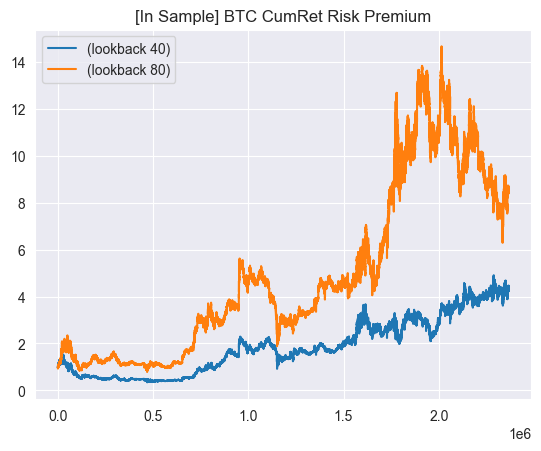

In [41]:
import matplotlib.pyplot as plt
for lookback, pnl in zip(vol_lookback_window[:], res_gross_pnl[:]):
    p = (pnl + 1).cumprod().reset_index(drop=True).plot(label=f'(lookback {lookback})')
plt.legend(loc="best")
plt.title("[In Sample] BTC CumRet Risk Premium")

In [42]:
# Now finally, it's time to put two signals together and see the magic happens
# 50% for each signal, 
# trends signal: cross_over - equal weight moving average cross over
# cross_over_3_9, cross_over_4_12
# vol signal: use the change of sd to indicate the volatility risk premium signal
# risk_premium_320_40, risk_premium_320_80

final_rets = pd.DataFrame()
for v in vol_signal:
    final_rets = pd.concat([final_rets, v], axis=1)
trends_signal = trends_signal[:2]
for t in trends_signal:
    final_rets = pd.concat([final_rets, t], axis=1)


Text(0.5, 1.0, '[In Sample] BTC CumRet')

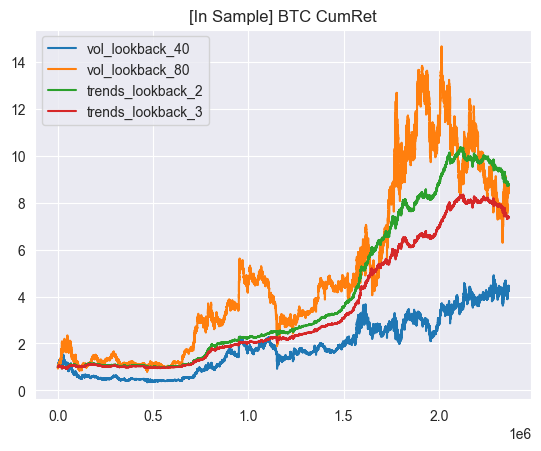

In [43]:
p = (final_rets + 1).cumprod().reset_index(drop=True).plot(label='final_signal')
plt.legend(loc="best")
plt.title("[In Sample] BTC CumRet")

The gross return is 42.35985199651278
The volatility is 35.13872206696167
The gross sharpe ratio is 1.2055034874572346


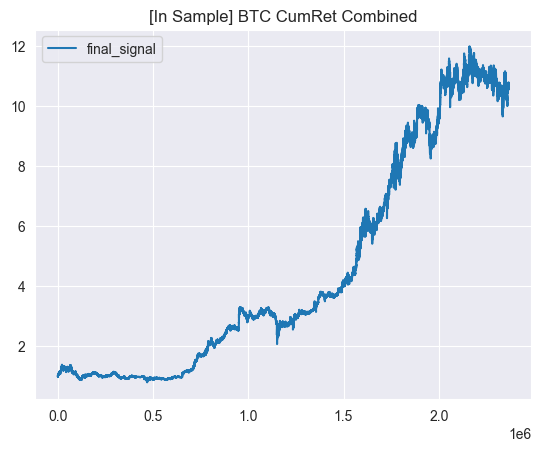

In [44]:
# now combine the four signals together from final_pl
# 25% for each signal
final_rets['final_signal'] = final_rets.mean(axis=1)
p = (final_rets['final_signal']  + 1).cumprod().reset_index(drop=True).plot(label='final_signal')
plt.legend(loc="best")
plt.title("[In Sample] BTC CumRet Combined")

# calculate the sharpe ratio, return and volatility
gross_return = final_rets['final_signal'].mean() * 100 * 252 * 60 * 24
vol = final_rets['final_signal'].std() * 100 * np.sqrt(252 * 60 * 24)
gross_sr = final_rets['final_signal'].mean() * 100 * 252 * 60 * 24 / vol
# print the sharpe ratio, return and volatility
print(f'The gross return is {gross_return}')
print(f'The volatility is {vol}')
print(f'The gross sharpe ratio is {gross_sr}')


# Now for out of sample 

In [45]:
data_os = data_os[200000:]
lookback_window = [2,3]
res_gross_pnl, stats_df = run_backtest_trends(data_os, use_so=True, use_mfi=False, use_regime=True, lookback_window=lookback_window)
trends_signal = res_gross_pnl.copy() 
for v, lookback in zip(trends_signal, lookback_window):
    v.name = f"trends_lookback_{lookback}"
stats_df

,lookback_2,lookback_3
avg_abs_pos,0.2947,0.3068
gross_return,44.5160,43.4597
net_return,44.5160,43.4597
vol,19.3337,19.9283
gross_sr,2.3025,2.1808
net_sr,2.3025,2.1808
tc,0.0000,0.0000
signal_turnover,55138.0228,39644.4170
max_dd,-20.2416,-12.8260


Text(0.5, 1.0, '[Out of Sample] BTC CumRet Trends + Stocastic Oscillator + Regime')

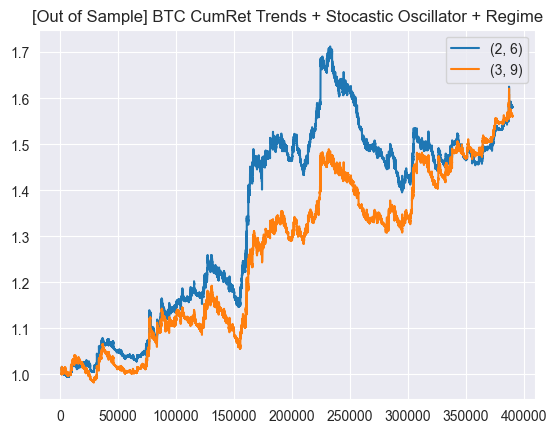

In [46]:
import matplotlib.pyplot as plt
for lookback, pnl in zip(lookback_window[:], res_gross_pnl[:]):
    p = (pnl + 1).cumprod().reset_index(drop=True).plot(label=f'({lookback}, {lookback * 3})')
plt.legend(loc="best")
plt.title("[Out of Sample] BTC CumRet Trends + Stocastic Oscillator + Regime")

In [47]:
# lookback 320, vol_lookback 40
# lookback 320, vol_lookback 80
lookback_window = [320]
vol_lookback_window = [40, 80]
res_gross_pnl, stats_df = run_backtest_volpremium(data_os, use_so=False, use_mfi=False, lookback_window=lookback_window, vol_lookback_window=vol_lookback_window)
vol_signal = res_gross_pnl.copy()
for v, lookback in zip(vol_signal, vol_lookback_window):
    v.name = f"vol_lookback_{lookback}"
stats_df


,lookback_320 vol_lookback_40,lookback_320 vol_lookback_80
avg_abs_pos,0.9991,0.9990
gross_return,65.0628,97.3605
net_return,65.0628,97.3605
vol,35.3305,35.3011
gross_sr,1.8415,2.7580
net_sr,1.8415,2.7580
tc,0.0000,0.0000
signal_turnover,10675.2923,6226.7116
max_dd,-23.5344,-17.5774


Text(0.5, 1.0, '[Out of Sample] BTC CumRet Risk Premium')

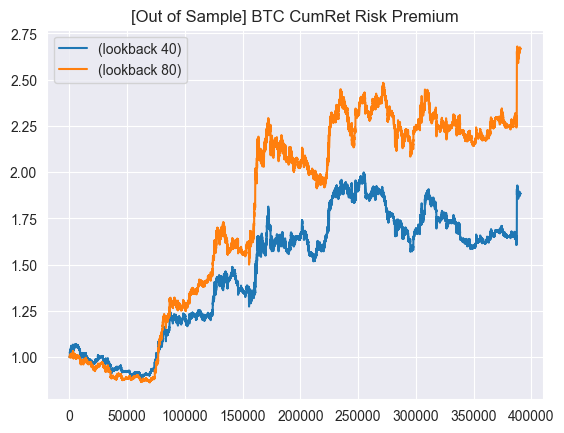

In [48]:
import matplotlib.pyplot as plt
for lookback, pnl in zip(vol_lookback_window[:], res_gross_pnl[:]):
    p = (pnl + 1).cumprod().reset_index(drop=True).plot(label=f'(lookback {lookback})')
plt.legend(loc="best")
plt.title("[Out of Sample] BTC CumRet Risk Premium")

Text(0.5, 1.0, '[Out of Sample] BTC CumRet')

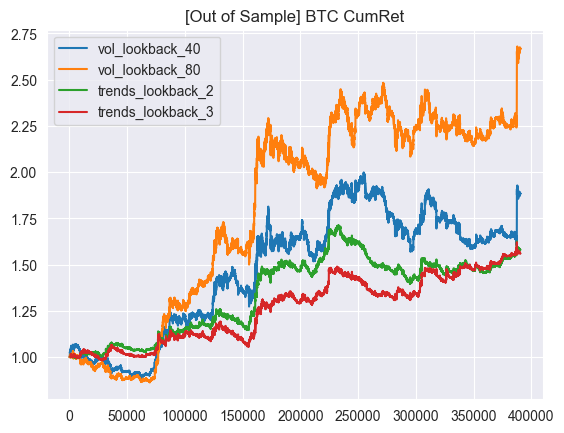

In [49]:
# Now finally, it's time to put two signals together and see the magic happens
final_rets = pd.DataFrame()
for v in vol_signal:
    final_rets = pd.concat([final_rets, v], axis=1)
trends_signal = trends_signal[:2]
for t in trends_signal:
    final_rets = pd.concat([final_rets, t], axis=1)
    
p = (final_rets + 1).cumprod().reset_index(drop=True).plot(label='final_signal')
plt.legend(loc="best")
plt.title("[Out of Sample] BTC CumRet")

The gross return is 63.55087090235466
The volatility is 19.27190977442059
The gross sharpe ratio is 3.2975907238163336


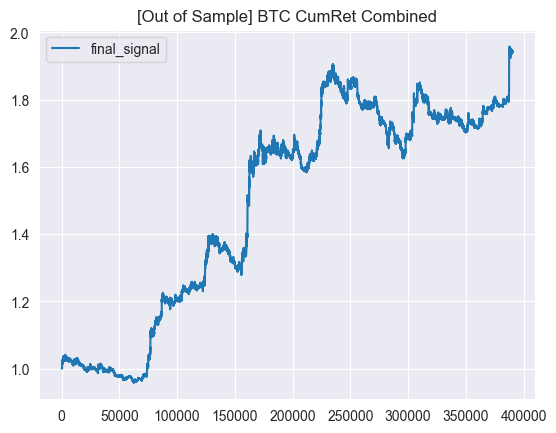

In [50]:
# now combine the four signals together from final_pl
# 25% for each signal
final_rets['final_signal'] = final_rets.mean(axis=1)
p = (final_rets['final_signal']  + 1).cumprod().reset_index(drop=True).plot(label='final_signal')
plt.legend(loc="best")
plt.title("[Out of Sample] BTC CumRet Combined")

# calculate the sharpe ratio, return and volatility
gross_return = final_rets['final_signal'].mean() * 100 * 252 * 60 * 24
vol = final_rets['final_signal'].std() * 100 * np.sqrt(252 * 60 * 24)
gross_sr = final_rets['final_signal'].mean() * 100 * 252 * 60 * 24 / vol
# print the sharpe ratio, return and volatility
print(f'The gross return is {gross_return}')
print(f'The volatility is {vol}')
print(f'The gross sharpe ratio is {gross_sr}')